In [1]:
!python --version
!pip3.7 list

Python 3.7.9
Package               Version

You should consider upgrading via the 'e:\ml\net2vec\venv\scripts\python.exe -m pip install --upgrade pip' command.



--------------------- -----------
absl-py               2.1.0
aiofiles              22.1.0
aiosqlite             0.19.0
anyio                 3.7.1
argon2-cffi           23.1.0
argon2-cffi-bindings  21.2.0
astor                 0.8.1
attrs                 23.2.0
Babel                 2.14.0
backcall              0.2.0
beautifulsoup4        4.12.3
bleach                6.0.0
certifi               2024.6.2
cffi                  1.15.1
charset-normalizer    3.3.2
colorama              0.4.6
cycler                0.11.0
debugpy               1.7.0
decorator             5.1.1
defusedxml            0.7.1
entrypoints           0.4
exceptiongroup        1.2.1
fastjsonschema        2.20.0
fonttools             4.38.0
gast                  0.2.2
google-pasta          0.2.0
grpcio                1.62.2
h5py                  3.8.0
idna                  3.7
importlib-metadata    6.7.0
importlib-resources   5.12.0
ipykernel             6.16.2
ipython               7.34.0
ipython-genutils      0.2.0

In [ ]:
#wyłączenie ostrzerzeń tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Utowrzenie próbek
!python .\mpnn\samples.py -N 2000 -o eval.tfrecords

2024-06-18 20:48:32.458702 Random response: 734205
2024-06-18 20:48:32.459685 generated 0 samples.
2024-06-18 20:48:33.686361 generated 500 samples.
2024-06-18 20:48:34.793175 generated 1000 samples.
2024-06-18 20:48:35.872885 generated 1500 samples.


2024-06-18 20:48:29.959863: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_100.dll'; dlerror: cudart64_100.dll not found
2024-06-18 20:48:29.959896: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



In [3]:
import tensorflow as tf
import numpy as np
import datetime

import mpnn.graph_nn as gnn
import matplotlib.pyplot as plt
%matplotlib inline

args = gnn.args

Using GRU architecture for upadate layer


In [4]:
def make_set():
    ds = tf.data.TFRecordDataset([args.eval])
    ds = ds.batch(args.batch_size)
    serialized_batch = ds.make_one_shot_iterator().get_next()
    return serialized_batch

In [5]:
g=tf.Graph()

with g.as_default():
    global_step = tf.train.get_or_create_global_step()
    with tf.variable_scope('model'):
        serialized_batch = make_set()
        batch, labels = gnn.make_batch(serialized_batch)
        n_batch = tf.layers.batch_normalization(batch) 
        predictions = gnn.inference(n_batch)
    loss= tf.losses.mean_squared_error(labels,predictions)        
    
    saver = tf.train.Saver(tf.trainable_variables() + [global_step])




Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use the `axis` argument instead


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.




Loading checkpint: log\model.ckpt-8000

INFO:tensorflow:Loading checkpint: log\model.ckpt-8000
INFO:tensorflow:Restoring parameters from log\model.ckpt-8000
(1024, 1)
2024-06-18 20:48:42.727318 step: 8000 mse: 0.0008525780285708606 R**2: 0.9581208117306232 Pearson: 0.9806275255146533


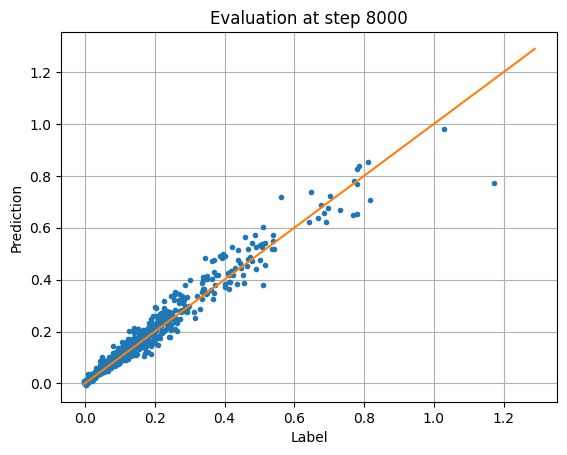

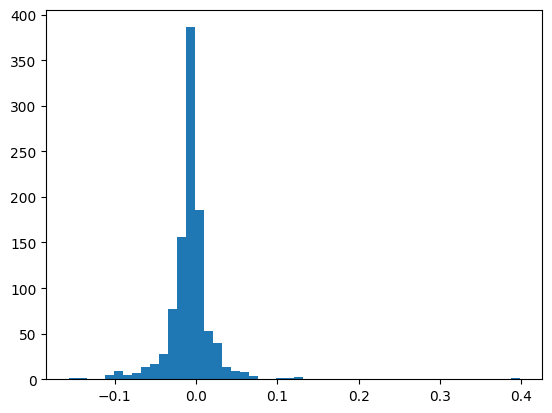

In [6]:
with tf.Session(graph=g) as ses:
    ses.run(tf.local_variables_initializer())
    ses.run(tf.global_variables_initializer())
    ckpt=tf.train.latest_checkpoint(args.log_dir)
    if ckpt:
        print("Loading checkpint: %s" % (ckpt))
        tf.logging.info("Loading checkpint: %s" % (ckpt))
        saver.restore(ses, ckpt)
    
    label_py=[]
    predictions_py=[]
    for i in range(16):
        val_label_py, val_predictions_py, step = ses.run( [labels,predictions, global_step] )
        label_py.append(val_label_py)
        predictions_py.append(val_predictions_py)
    label_py = np.concatenate(label_py,axis=0)
    predictions_py = np.concatenate(predictions_py,axis=0)
    print(label_py.shape)
    print('{} step: {} mse: {} R**2: {} Pearson: {}'.format(
        str(datetime.datetime.now()),
        step,
        np.mean((label_py-predictions_py)**2),
        #np.max(np.abs(test_error)),
        gnn.fitquality(label_py,predictions_py),
        np.corrcoef(label_py,predictions_py, rowvar=False)[0,1] ), flush=True ) 
    plt.figure()
    plt.plot(label_py,predictions_py,'.')
    gnn.line_1(label_py, label_py)
    plt.grid('on')
    plt.xlabel('Label')
    plt.ylabel('Prediction')
    plt.title('Evaluation at step {}'.format(step))
    fig_path = os.path.join(args.log_dir,'eval-{0:08}.png'.format(step) )
    fig_path = 'eval.pdf'.format(step)
    plt.show()
    plt.close()
    plt.figure()
    plt.hist(label_py-predictions_py, 50)
    fig_path = 'rez_hist.pdf'
    plt.show()
    plt.close()

message passing

message

update

# Rodzaje rekurencyjnych sieci neuronowych(RNN)

## Prosta sieć neuronowa (Vanilla)
![image](images/rnn_diagram.webp)  
*Praveen Raj, Medium.com*

* Najprostsze obliczeniowo podejście
* Stosowanie **backpropagation** analogiczne jak w klasycznych sieciach neuronowych
* Podatne na **exploding gradient** i **vanishing gradient**
    * 1,1^50 ~= 117
    * 0,9^50 ~= 0,005

In [ ]:
N_H = args.pad + 2

def U_RNN(h, m, x, flag, c):
        with tf.variable_scope('update'):
            # na wejście warstwy wchodzi suma stanu ukrytego (h) i wiadomości (m)
            hm = h + m
            # ustawienie ostatinego elementu tensora na warość flagi identyfikującej wierzchołek
            hm = tf.concat([hm[:, :-1], flag], axis = 1)
            # pojedynczy perceptron z aktywacją ReLU
            u = tf.layers.dense(hm, N_H, activation = tf.nn.relu)
            # nowy stan ukryty (u) - update
            return u, c

## Long short-term memory (LSTM)

![image](images/LSTM_Cell.svg.png)  
*Wikimedia Commons*

* Dobrze radzi sobie z długofalowymi (wiele kroków) relacjami
* Złagodzenie problemu vaniching gradient
* Istnieją warianty dwukierunkowe, przydatne w problemach w których można wnioskować z poprzednich i następujących danych
* Duża ilość prametrów i operacji
    * wymaga więcej mocy obliczeniowej
    * podatne na overfitting
* Trudność w interpretacji

In [ ]:
def U_LSTM(h, m, x, flag, c):
        with tf.variable_scope('update'):
            bf = tf.get_variable(name='bf', shape=(N_H,), dtype=tf.float32)
            wf = tf.get_variable(name='wf', shape=(N_H, N_H), dtype=tf.float32)
            uf = tf.get_variable(name='uf', shape=(N_H, N_H), dtype=tf.float32)
            bi = tf.get_variable(name='bi', shape=(N_H,), dtype=tf.float32)
            wi = tf.get_variable(name='wi', shape=(N_H, N_H), dtype=tf.float32)
            ui = tf.get_variable(name='ui', shape=(N_H, N_H), dtype=tf.float32)
            bo = tf.get_variable(name='bo', shape=(N_H,), dtype=tf.float32)
            wo = tf.get_variable(name='wo', shape=(N_H, N_H), dtype=tf.float32)
            uo = tf.get_variable(name='uo', shape=(N_H, N_H), dtype=tf.float32)
            bc = tf.get_variable(name='bc', shape=(N_H,), dtype=tf.float32)
            wc = tf.get_variable(name='wc', shape=(N_H, N_H), dtype=tf.float32)
            uc = tf.get_variable(name='uc', shape=(N_H, N_H), dtype=tf.float32)

            # ustawienie ostatinego elementu tensora na warość flagi identyfikującej wierzchołek
            h = tf.concat([h[:, :-1], flag], axis = 1)

            # forget gate
            ft = tf.nn.sigmoid(tf.matmul(m, wf) + tf.matmul(h, uf) + bf)
            # input gate
            it = tf.nn.sigmoid(tf.matmul(m, wi) + tf.matmul(h, ui) + bi)
            # output gate
            ot = tf.nn.sigmoid(tf.matmul(m, wo) + tf.matmul(h, uo) + bo)
            # potencjalny kandydat (c~)
            c_tylda = tf.nn.tanh(tf.matmul(m, wc) + tf.matmul(h, uc) + bc)
            # nowy kandydat (c) - stary * forget gate + potencjalny * input gate
            c = tf.math.multiply(ft, c) + tf.math.multiply(it, c_tylda)
            # stan ukryty/update (u) = kandydat (c) * output gate
            u = tf.math.multiply(ot, tf.nn.tanh(c))
            return u, c

## Gated Reccurent Unit (GRU)
![image](images/Gated_Recurrent_Unit,_base_type.svg.png)

* mniej złożona od LSTM (3 operacje maierzowe i 1 *element-wise* do 4 operacji macierzowyc i 2 *element-wise*)
    * szybsze uczenie modelu
    * mniej podatne na overfitting
* dobrze radzi sobi z problemem vanishing gradient
* może radzić sobie gorzej z długofalowymi zależnościami
* w wielu praktycznych zastowoniach osiąga wyniki porównywalne z LSTM, niekiedy lepsze

In [ ]:
def U_GRU(h, m, x, flag, c):
    with tf.variable_scope('update'):
        wz=tf.get_variable(name='wz',shape=(N_H,N_H),dtype=tf.float32)
        uz=tf.get_variable(name='uz',shape=(N_H,N_H),dtype=tf.float32)
        wr=tf.get_variable(name='wr',shape=(N_H,N_H),dtype=tf.float32)
        ur=tf.get_variable(name='ur',shape=(N_H,N_H),dtype=tf.float32)
        W=tf.get_variable(name='W',shape=(N_H,N_H),dtype=tf.float32)
        U=tf.get_variable(name='U',shape=(N_H,N_H),dtype=tf.float32)

        # ustawienie ostatinego elementu tensora na warość flagi identyfikującej wierzchołek
        h = tf.concat([h[:, :-1], flag], axis = 1)
        # update gate
        z = tf.nn.sigmoid(tf.matmul(m,wz) + tf.matmul(h,uz))
        # reset gate
        r = tf.nn.sigmoid(tf.matmul(m,wr) + tf.matmul(h,ur))
        # candidate hidden state (h~)
        h_tylda = tf.nn.tanh(tf.matmul(m,W) + tf.matmul(r*h,U) )
        # final fidden state/update (u)
        u = (1.0-z)*h + z*h_tylda
        return u, c

## Porównanie
### 2000 kroków
![img](images/2k_eval.png)
![img](images/2k_plot.png)
### 8000 kroków
![img](images/8k_eval.png)
![img](images/8k_plot.png)
### 20 000 kroków
![img](images/20k_eval.png)
![img](images/20k_plot.png)

readout

### Źródła
-  Krzysztof Rusek and Piotr Chołda, ''Message-Passing Neural Networks Learn Little's Law'', IEEE Communications Letters, 2018